In [1]:
import os
from datetime import datetime, timezone

from alpaca.data.historical import CryptoHistoricalDataClient, StockHistoricalDataClient
from alpaca.trading.client import TradingClient

from maiagomes.data import Pull_bars_from_alpaca
from maiagomes.models.allocate import Allocate_arma

from maiagomes.testing import Data_handler,testEnv


time_series_df_path="../../../investing_poc/data/mining/merged/all_quotes.csv"


allocator = Allocate_arma(
    time_series_df_path=time_series_df_path,
    remap={"FB": "META"},
    blacklisted_symbols=["BNB", "XRP", "ADA", "PBR-A"],
)
stock_client = StockHistoricalDataClient(
    os.getenv("APCA_API_KEY_ID"), os.getenv("APCA_API_SECRET_KEY")
)
crypto_client = CryptoHistoricalDataClient()
trading_client = TradingClient(
    os.getenv("APCA_API_KEY_ID"), os.getenv("APCA_API_SECRET_KEY"), paper=True
)
latest_values = Pull_bars_from_alpaca(
    stock_client, crypto_client, start=datetime(2023, 1, 1)
).pull(allocator.symbols)

latest_values['Date'] = latest_values['timestamp'].map(lambda a: a.replace(tzinfo=None))
latest_values.columns = [v.replace("/USD","") for v in latest_values]
df = latest_values.loc[latest_values["timestamp"] >= datetime(2023,2,1).astimezone(),].drop(columns = ['timestamp'])
data = Data_handler(df = df.ffill(), 
                    date_var="Date", add_cash=True)


from glob import glob
import json

mmar_results = {}
for __file__ in glob("../data/old_model_results/*"):
    date = __file__.split("/")[-1].split("_")[-1].replace(".json","")
    _ = json.load(open(__file__,"rb"))
    mmar_results[date] = {k:v for k,v in _.items() if k in data.symbolList}

from maiagomes.models.allocate import (
    get_arma_portfolio,
    get_mmar_portfolio,
    get_random_portfolio,
    get_simple_portfolio,
)


In [2]:
from glob import glob
import json

mmar_results = {}
for __file__ in glob("../data/old_model_results/*"):
    date = __file__.split("/")[-1].split("_")[-1].replace(".json","")
    _ = json.load(open(__file__,"rb"))
    mmar_results[date] = {k:v for k,v in _.items() if k in data.symbolList}

In [3]:
import logging
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import dirichlet, multinomial, norm
from itertools import product

logger = logging.getLogger(__name__)


def get_mmar_portfolio_wrapper(
    *args, mmar_results=mmar_results, symbolList=data.symbolList
):
    return get_mmar_portfolio(
        *args, mmar_results=mmar_results, symbolList=symbolList
    )



def auto_tune_arima(
    ts, p_values=range(0, 3), d_values=range(0, 2), q_values=range(0, 3)
):
    split_point = int(len(ts) * 0.9)  # Adjust the split percentage as needed

    # Split the time series into training and testing sets
    train_data = ts[:split_point]
    test_data = ts[split_point:]
    best_mse = float("inf")
    best_order = None

    for p, d, q in product(p_values, d_values, q_values):
        model = sm.tsa.ARIMA(train_data, order=(p, d, q))
        try:
            results = model.fit()
            predicted = results.get_forecast(steps=len(test_data))
            error = predicted.predicted_mean - test_data
            mse = (error**2).sum()
            # aic = results.aic
            if mse < best_mse:
                best_mse = mse
                best_order = (p, d, q)
        except:
            continue
    return best_order


def get_arma_prediction(ts, p=1, d=1, q=0, **kwargs):
    if p == -1 or q == -1:
        order = auto_tune_arima(ts, **kwargs)
    else:
        order = (p, d, q)
    model = sm.tsa.ARIMA(ts, order=order)
    results = model.fit()

    forecast_values = results.get_forecast(steps=1)
    return forecast_values


def get_arma_expected_return(ts, stdize=False, **kwargs):
    preds = get_arma_prediction(ts, **kwargs)
    ans = np.log(preds.predicted_mean) - np.log(ts[-1])
    if stdize:
        ans += -np.log(preds.se_mean)
    return ans



def get_kelly_c(p, a=1.0, b=1.0):
    _a_ = np.max([a, -1.0 * np.min([0, b])])
    _b_ = np.max([b, -1.0 * np.min([0, a])])
    return p / _a_ - (1 - p) / _b_


def get_arma_win_probability(ts, **kwargs):
    preds = get_arma_prediction(ts, **kwargs)
    diff = preds.predicted_mean - ts[-1]
    p = norm.cdf(diff / preds.se_mean)
    return get_kelly_c(p, b=np.exp(diff)[0])


def get_arma_portfolio(historyPrices, currDate, past_size=10, p=1, d=1, q=-1, **kwargs):
    if historyPrices.shape[0] <= past_size:
        return get_simple_portfolio(historyPrices, currDate)
    expected_returns = np.zeros(historyPrices.shape[1])
    for i in range(historyPrices.shape[1] - 1):
        expected_returns[i] = get_arma_win_probability(
            np.log(historyPrices[:, i]), p=p, d=d, q=q, **kwargs
        )[0]
    _expected_returns_ = np.nan_to_num(expected_returns, nan=0)
    _expected_returns_ = _expected_returns_ * (_expected_returns_ > 0)
    if _expected_returns_.sum() > 1:
        logger.warning(
            f"Allocation suggests leveraging: {_expected_returns_.sum()} > 1 "
        )
        _expected_returns_ /= _expected_returns_.sum()
    elif _expected_returns_.sum() < 1:
        logger.warning(
            f"Allocation suggests saving {1- _expected_returns_.sum():.3%} in cash."
        )
        _expected_returns_[-1] = 1 - _expected_returns_.sum()
    return _expected_returns_.reshape([1, -1])


def adjust_allocation(_expected_returns_,_rho_):
    final_allocation = np.zeros(_expected_returns_.shape)
    argm = _expected_returns_.argmax()
    alloc = _expected_returns_[argm] 
    final_allocation[argm] = alloc
    while alloc > .01 and alloc <= 1:
        _rho_[:,argm] = 1
        _expected_returns_ = ((1-alloc)*_expected_returns_)*(1-_rho_[argm,])
        argm = _expected_returns_.argmax()
        alloc = _expected_returns_[argm] 
        final_allocation[argm] = alloc

    return final_allocation

def get_arma_portfolio(historyPrices, currDate, past_size=10, p=2, d=1, q=-1, **kwargs):
    if historyPrices.shape[0] <= past_size:
        return get_simple_portfolio(historyPrices, currDate)
    expected_returns = np.zeros(historyPrices.shape[1])
    for i in range(historyPrices.shape[1] - 1):
        try:
            expected_returns[i] = get_arma_win_probability(
                np.log(historyPrices[:, i]), p=p, d=d, q=q, **kwargs
            )[0]
        except Exception as e:
            print(f"Problems getting expected returns: {e}")
            continue
    _expected_returns_ = np.nan_to_num(expected_returns, nan=0)
    _expected_returns_ = _expected_returns_ * (_expected_returns_ > 0)
    lnmat = np.diff(np.log(historyPrices),axis = 0)
    lnmat_discretized = -1 * (lnmat < 0) + (lnmat > 0)
    weighted_graph = lnmat_discretized.T.dot(lnmat_discretized)
    weighted_graph_sum = (1.0 * (lnmat_discretized != 0)).T.dot(
        1.0 * (lnmat_discretized != 0)
    )
    _rho_ = np.nan_to_num(abs(weighted_graph / weighted_graph_sum))
    # _rho_ = np.nan_to_num(abs(np.corrcoef(lnmat.T)))
    _expected_returns_ = adjust_allocation(_expected_returns_,_rho_)
    if _expected_returns_.sum() > 1:
        logger.warning(
            f"Allocation suggests leveraging: {_expected_returns_.sum()} > 1 "
        )
        _expected_returns_ /= _expected_returns_.sum()
    elif _expected_returns_.sum() < 1:
        logger.warning(
            f"Allocation suggests saving {1- _expected_returns_.sum():.3%} in cash."
        )
        _expected_returns_[-1] = 1 - _expected_returns_.sum()
    return _expected_returns_.reshape([1, -1])


def get_mmar_portfolio(
    historyPrices,
    currDate,
    mmar_results=None,
    min_date=datetime(2021, 11, 2, 0, 0),
    symbolList=None,
):
    latest_results_date = currDate.astype("datetime64[D]")
    results_do_not_exist = str(latest_results_date) not in mmar_results.keys()
    while results_do_not_exist:
        latest_results_date -= 1
        if datetime.strptime(str(latest_results_date), "%Y-%m-%d") < min_date:
            return get_simple_portfolio(historyPrices, currDate)
        else:
            results_do_not_exist = str(latest_results_date) not in mmar_results.keys()
    currEstimates = mmar_results[str(latest_results_date)]
    df = pd.DataFrame(currEstimates).T
    df["norm_mu"] = df["mu"] / np.sqrt(df["sigma2"] / df["N"])
    p = dirichlet.rvs(df.norm_mu.values)[0]
    df["alloc"] = p
    allocs = df.alloc.to_dict()
    ans = np.zeros(len(symbolList))
    for i, sym in enumerate(symbolList):
        if sym in allocs.keys():
            ans[i] = allocs[sym]
    ans /= ans.sum()
    return ans


def get_arma_portfolio_wrapper_1_1_0(*args):
    return get_arma_portfolio(*args,p=1,d=1,q=0)

def get_arma_portfolio_wrapper_1_1_1(*args):
    return get_arma_portfolio(*args,p=1,d=1,q=1)

def get_arma_portfolio_wrapper_2_1_0(*args):
    return get_arma_portfolio(*args,p=2,d=1,q=0)

def get_arma_portfolio_wrapper_2_1_1(*args):
    return get_arma_portfolio(*args,p=2,d=1,q=1)


strategies = {
    "market": get_simple_portfolio,
    "random": get_random_portfolio,
    "mmar": get_mmar_portfolio_wrapper,
    # "arma(1,1,0)": get_arma_portfolio_wrapper_1_1_0,
    # "arma(1,1,1)": get_arma_portfolio_wrapper_1_1_1,
    # "arma(2,1,0)": get_arma_portfolio_wrapper_2_1_0,
    "arma(2,1,1)": get_arma_portfolio_wrapper_2_1_1,
}


In [7]:
test = testEnv(data, interval_period="D",within_period = 'last')

In [8]:
rois = test.simulate(
        strategies=strategies, reinvest_amount=0, buy_and_hold=False, showProgress=True
    )

  0%|          | 0/403 [00:00<?, ?it/s]/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/var/folders/93/g3mybg_57p16jzvjbpkk1jlw0000gn/T/ipykernel_7071/2516359271.py:138: RuntimeWarning: invalid value encountered in divide
  _rho_ = np.nan_to_num(abs(weighted_graph / weighted_graph_sum))
Allocation suggests saving 0.520% in cash.
  2%|▏         | 10/403 [00:09<06:09,  1.06it/s]/Users/guilhermegomes/Documents/maiagomes/maiagomes/.venv/lib/python3.11/site-packages/statsmode

In [14]:
mat = rois[1]['arma(2,1,1)']

In [19]:
mat /= mat.sum(axis = 1,keepdims=True)

<Axes: >

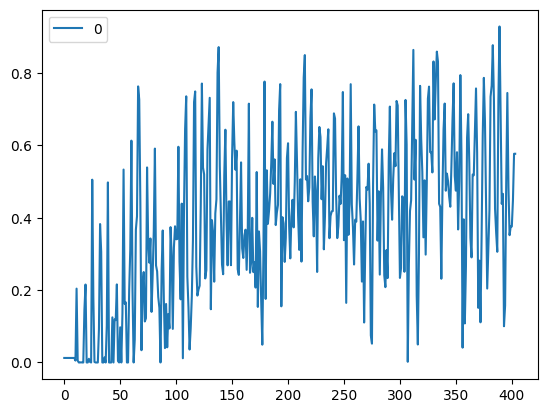

In [23]:
pd.DataFrame(mat[:,-1]).plot()

<Axes: >

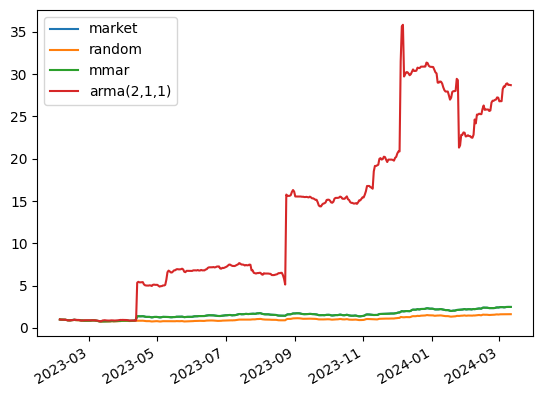

In [11]:
pd.DataFrame(rois[0]).plot()

<Axes: >

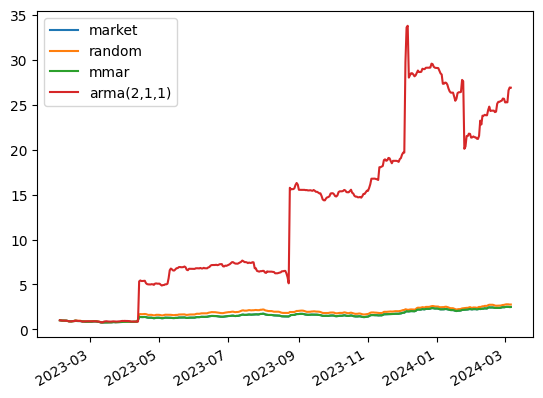

In [16]:
pd.DataFrame(rois[0]).plot()

<Axes: >

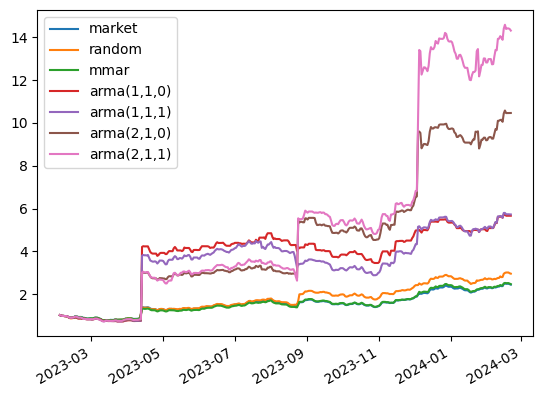

In [ ]:
pd.DataFrame(rois[0]).plot()

<Axes: >

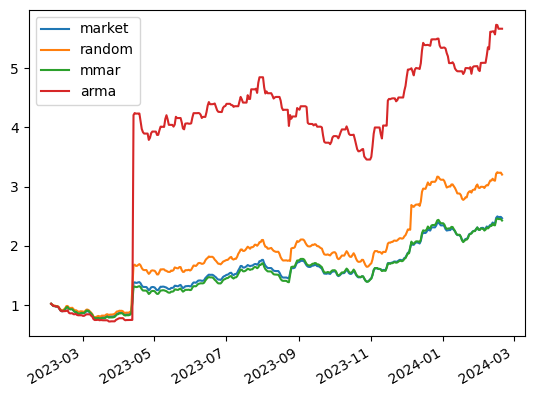

In [ ]:
pd.DataFrame(rois[0]).plot()